In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from os import chdir 
from tqdm import tqdm
from glob import glob
from pathlib import Path

%matplotlib inline
%reload_ext autoreload
%autoreload 2
chdir('C:\\Users\\afeki\\Desktop\\Code\\BootStrapDesicionTree\\')

In [2]:
from gradient_boosting_trees.gradient_boosting_regressor import CartGradientBoostingRegressor, \
    CartGradientBoostingRegressorKfold

# Config

In [3]:
A1 = 3
A2 = 2
SIGMNA = 10
N_ROWS = 10**3
CATEGORICAL_DISTRIBUTION = 'uniform'
CATEGORY_SIZE = 10
CATEGORY_COLUMN_NAME = 'random_category'
Y_COL_NAME = 'y'
SEED = 3
CATEGORIES = np.arange(10, 210, 10)
N_EXPERIMENTS = 5

In [4]:
MAX_DEPTH = 4
N_ESTIMATORS = 100
LEARNING_RATE = 0.1

# Create simulated data
$$ y = a_1 \cdot x_1 + a_2 \cdot x_2 + \sigma $$

$$ x1 - N(0,1) $$
$$ x2 - N(0,1) $$
Add another column of categorical features

In [9]:
def create_x_y(category_size):
    X = pd.DataFrame()
    X['x1'] = np.random.randn(N_ROWS)
    X['x2'] = np.random.randn(N_ROWS)
    sigma = SIGMNA*np.random.randn(N_ROWS)
    y = A1*X['x1'] + A2*X['x2'] + sigma
    X[CATEGORY_COLUMN_NAME] = np.random.randint(0, category_size, N_ROWS)
    X[CATEGORY_COLUMN_NAME] = X[CATEGORY_COLUMN_NAME].astype('category')
    return X, y

# OUR IMPLEMENTATION
## KFOLD

In [5]:
plot_df = pd.DataFrame(index = CATEGORIES)

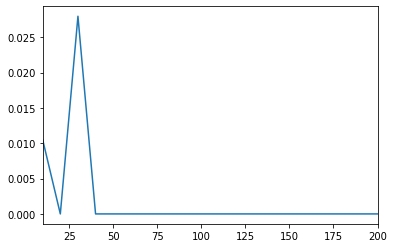

In [6]:
def plot_csv_results(exp):
    results = {category: [] for category in CATEGORIES}
    mean_results = {category: 0 for category in CATEGORIES}
    paths = [Path(path) for path in glob(F"experiments/detect_uninformative_feature_simulated_data/results/*{exp}*.csv")]
    for path in paths:
        category = int(path.stem.split("_")[-1])
        results[category].append(pd.read_csv(path, index_col = 0, names = ['fi'], skiprows = 1)['fi'][CATEGORY_COLUMN_NAME])

    for cat, results_list in results.items():
        mean_results[cat] = np.mean(results_list)
    mean_results = pd.Series(mean_results)
    mean_results.plot()
    plt.show()
    return mean_results

def plot_results(results):
    results = pd.DataFrame(final_results/N_EXPERIMENTS, index = CATEGORIES)
    results['sum_'] = 1- (results[0]+ results[1]) 
    results['sum_'].plot()
    plt.show()
    return results['sum_']
    

plot_df['Ours_With_Cross_Validation'] = plot_csv_results('kfold')

## Vanilla gradient boosting regressor

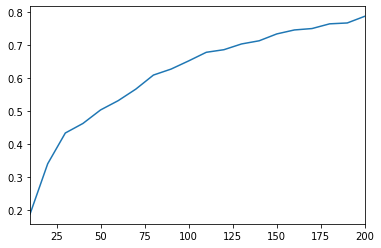

In [7]:
plot_df['Ours_Vanilla'] = plot_csv_results('reg')

In [8]:
# from Tree.tree_visualizer import TreeVisualizer
# tree_vis = TreeVisualizer()
# tree_vis.plot(kfold_gbm.trees[27].root)

# SKLEARN
## One Hot

100%|██████████| 20/20 [00:03<00:00,  5.45it/s]


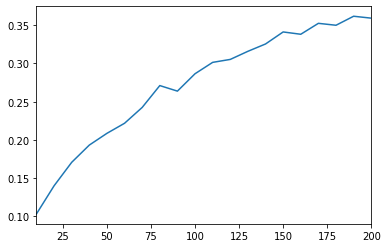

In [10]:
from sklearn.ensemble import GradientBoostingRegressor
final_results = np.zeros((len(CATEGORIES),2))
for exp in range(N_EXPERIMENTS):
    temp_results = []
    for category_size in tqdm(CATEGORIES, total=len(CATEGORIES)):
            np.random.seed(exp)
            X, y = create_x_y(category_size)
            clf = GradientBoostingRegressor(n_estimators=  N_ESTIMATORS, max_depth = MAX_DEPTH - 1,learning_rate = LEARNING_RATE)
            X_train = pd.get_dummies(X)
            clf.fit(X_train, y)
            fi = pd.Series(clf.feature_importances_, index = X_train.columns)
            temp_results.append([fi['x1'],fi['x2']])
    final_results += np.array(temp_results)
    
plot_df['Scikit_Learn_OneHot'] = plot_results(final_results)

## Mean Imputing

100%|██████████| 20/20 [00:00<00:00, 25.84it/s]


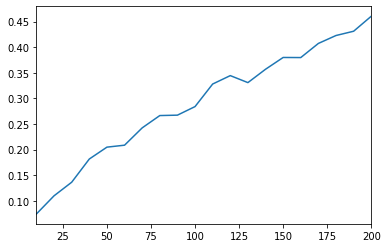

In [11]:
final_results = np.zeros((len(CATEGORIES),2))
for exp in range(N_EXPERIMENTS):
    temp_results = []
    for category_size in tqdm(CATEGORIES, total=len(CATEGORIES)):
            np.random.seed(exp)
            X, y = create_x_y(category_size)
            df = X.copy()
            df[Y_COL_NAME] = y
            category_to_mean = df[[CATEGORY_COLUMN_NAME,Y_COL_NAME]].groupby(CATEGORY_COLUMN_NAME)[Y_COL_NAME].mean().to_dict()
            X[CATEGORY_COLUMN_NAME] = X[CATEGORY_COLUMN_NAME].map(category_to_mean)
            X[CATEGORY_COLUMN_NAME] = X[CATEGORY_COLUMN_NAME].astype('float')
            clf = GradientBoostingRegressor(n_estimators=  N_ESTIMATORS, max_depth = MAX_DEPTH - 1,learning_rate = LEARNING_RATE)
            clf.fit(X, y)
            fi = pd.Series(clf.feature_importances_, index = X.columns)
            temp_results.append([fi['x1'],fi['x2']])
    final_results += np.array(temp_results)

plot_df['Scikit_Learn_MeanImputing'] =  plot_results(final_results)

# XGBOOST 
## One Hot

In [12]:
# !pip install xgboost
import xgboost as xgb

100%|██████████| 20/20 [00:04<00:00,  4.44it/s]


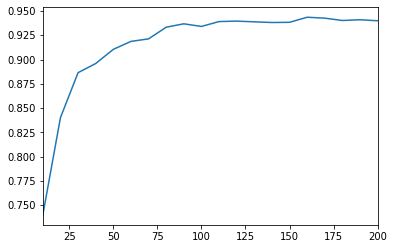

In [13]:
final_results = np.zeros((len(CATEGORIES),2))
for exp in range(N_EXPERIMENTS):
    temp_results = []
    for category_size in tqdm(CATEGORIES, total=len(CATEGORIES)):
            np.random.seed(exp)
            X, y = create_x_y(category_size)
            X_train = pd.get_dummies(X)
            dtrain = xgb.DMatrix(X_train, label=y)
            param = {'max_depth': MAX_DEPTH - 1, 'eta': LEARNING_RATE, 'objective': 'reg:squarederror'}
            num_round = N_ESTIMATORS
            bst = xgb.train(param, dtrain, num_round)
            fi = pd.Series(bst.get_score(importance_type='gain'))
            fi = fi/fi.sum()
            temp_results.append([fi['x1'],fi['x2']])
    final_results += np.array(temp_results)
    
plot_df['XGBOOST_OneHot'] = plot_results(final_results)  
# dtrain = xgb.DMatrix(pd.get_dummies(X), label=y)
# param = {'max_depth': MAX_DEPTH - 1, 'eta': LEARNING_RATE, 'objective': 'reg:linear'}
# num_round = N_ESTIMATORS
# bst = xgb.train(param, dtrain, num_round)
# fi = pd.Series(bst.get_score(importance_type='gain'))
# fi/fi.sum()
# xgb.plot_importance(bst)
# plt.show()

In [14]:
# xgb.plot_tree(bst,num_trees= 58)
# plt.rcParams['figure.figsize'] = [100, 20]
# plt.show()

## Mean Imputing

100%|██████████| 20/20 [00:01<00:00, 14.22it/s]


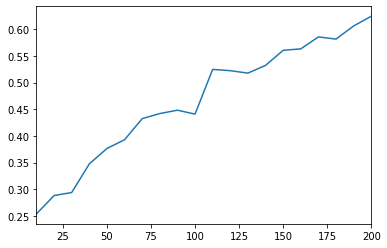

In [15]:
final_results = np.zeros((len(CATEGORIES),2))
for exp in range(N_EXPERIMENTS):
    temp_results = []
    for category_size in tqdm(CATEGORIES, total=len(CATEGORIES)):
            np.random.seed(exp)
            X, y = create_x_y(category_size)
            df = X.copy()
            df[Y_COL_NAME] = y
            category_to_mean = df[[CATEGORY_COLUMN_NAME,Y_COL_NAME]].groupby(CATEGORY_COLUMN_NAME)[Y_COL_NAME].mean().to_dict()
            X[CATEGORY_COLUMN_NAME] = X[CATEGORY_COLUMN_NAME].map(category_to_mean)
            X[CATEGORY_COLUMN_NAME] = X[CATEGORY_COLUMN_NAME].astype('float')
            dtrain = xgb.DMatrix(X, label=y)
            param = {'max_depth': MAX_DEPTH - 1, 'eta': LEARNING_RATE, 'objective': 'reg:squarederror'}
            num_round = N_ESTIMATORS
            bst = xgb.train(param, dtrain, num_round)
            fi = pd.Series(bst.get_score(importance_type='gain'))
            fi = fi/fi.sum()
            temp_results.append([fi['x1'],fi['x2']])
    final_results += np.array(temp_results)

plot_df['XGBOOST_MeanImputing'] = plot_results(final_results) 

In [16]:
# dtrain = xgb.DMatrix(X_m, label=y)
# param = {'max_depth': MAX_DEPTH - 1, 'eta': LEARNING_RATE, 'objective': 'reg:linear'}
# num_round = N_ESTIMATORS
# bst = xgb.train(param, dtrain, num_round)
# xgb.plot_importance(bst)
# plt.show()
# bst.get_score(importance_type='gain')

# CATBOOST
# One Hot

In [17]:
# !pip install catboost
# !pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
from catboost import Pool, CatBoostRegressor

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


100%|██████████| 20/20 [00:02<00:00,  6.73it/s]


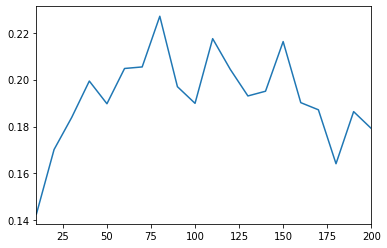

In [18]:
final_results = np.zeros((len(CATEGORIES),2))
for exp in range(N_EXPERIMENTS):
    temp_results = []
    for category_size in tqdm(CATEGORIES, total=len(CATEGORIES)):
            np.random.seed(exp)
            X, y = create_x_y(category_size)
            X_train = pd.get_dummies(X)
            train_pool = Pool(X_train, y)
            clf = CatBoostRegressor(iterations=N_ESTIMATORS, 
                          depth= MAX_DEPTH -1, 
                          learning_rate=LEARNING_RATE , 
                          loss_function='RMSE',logging_level = 'Silent')
            clf.fit(train_pool)
            fi = pd.Series(clf.feature_importances_, index = clf.feature_names_)
            fi = fi/fi.sum()
            temp_results.append([fi['x1'],fi['x2']])
    final_results += np.array(temp_results)
    
plot_df['CATBOOST_OneHot'] = plot_results(final_results) 

## Mean Impuitng

100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


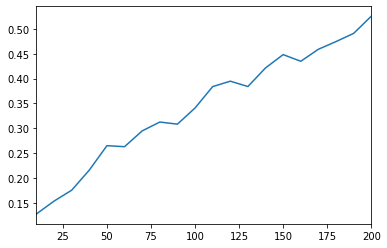

In [19]:
final_results = np.zeros((len(CATEGORIES),2))
for exp in range(N_EXPERIMENTS):
    temp_results = []
    for category_size in tqdm(CATEGORIES, total=len(CATEGORIES)):
            np.random.seed(exp)
            X, y = create_x_y(category_size)
            df = X.copy()
            df[Y_COL_NAME] = y
            category_to_mean = df[[CATEGORY_COLUMN_NAME,Y_COL_NAME]].groupby(CATEGORY_COLUMN_NAME)[Y_COL_NAME].mean().to_dict()
            X[CATEGORY_COLUMN_NAME] = X[CATEGORY_COLUMN_NAME].map(category_to_mean)
            X[CATEGORY_COLUMN_NAME] = X[CATEGORY_COLUMN_NAME].astype('float')
            train_pool = Pool(X, y)
            clf = CatBoostRegressor(iterations=N_ESTIMATORS, 
                          depth= MAX_DEPTH -1, 
                          learning_rate=LEARNING_RATE , 
                          loss_function='RMSE',logging_level = 'Silent')
            clf.fit(train_pool)
            fi = pd.Series(clf.feature_importances_, index = clf.feature_names_)
            fi = fi/fi.sum()
            temp_results.append([fi['x1'],fi['x2']])
    final_results += np.array(temp_results)


plot_df['CATBOOST_MeanImputing'] = plot_results(final_results)

## Categories

100%|██████████| 20/20 [00:02<00:00,  7.12it/s]


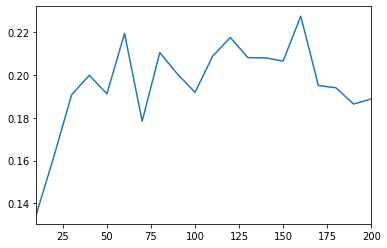

In [20]:
final_results = np.zeros((len(CATEGORIES),2))
for exp in range(N_EXPERIMENTS):
    temp_results = []
    for category_size in tqdm(CATEGORIES, total=len(CATEGORIES)):
            np.random.seed(exp)
            X, y = create_x_y(category_size)
            train_pool = Pool(X, y,  cat_features=[2])
            clf = CatBoostRegressor(iterations=N_ESTIMATORS, 
                          depth= MAX_DEPTH -1, 
                          learning_rate=LEARNING_RATE , 
                          loss_function='RMSE',logging_level = 'Silent')
            clf.fit(train_pool)
            fi = pd.Series(clf.feature_importances_, index = clf.feature_names_)
            fi = fi/fi.sum()
            temp_results.append([fi['x1'],fi['x2']])
    final_results += np.array(temp_results)
    
plot_df['CATBOOST_Vanilla'] = plot_results(final_results)

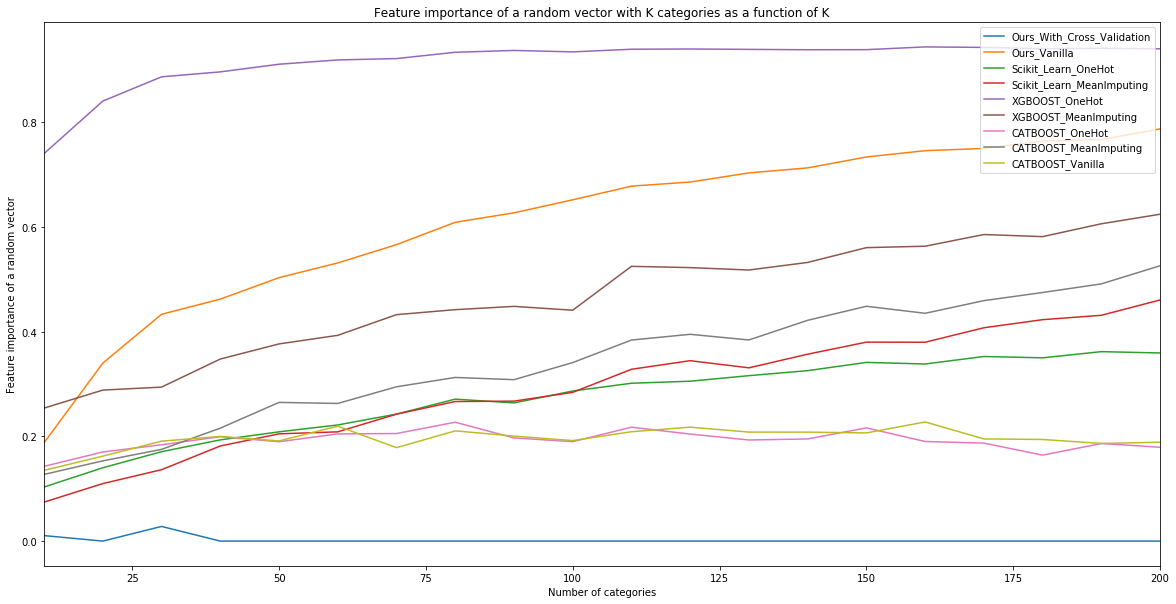

In [41]:
plt.rcParams['figure.figsize'] = [20, 10]
ax = plot_df.plot()
ax.set_xlabel("Number of categories")
ax.set_ylabel("Feature importance of a random vector")
ax.set_title("Feature importance of a random vector with K categories as a function of K")
plt.legend(loc='upper right')
plt.show()

In [22]:
# train_pool = Pool(X, 
#                   y, 
#                   cat_features=[2])

# # specify the training parameters 
# model = CatBoostRegressor(iterations=100, 
#                           depth=3, 
#                           learning_rate=0.1, 
#                           loss_function='RMSE')
# #train the model
# model.fit(train_pool)
# print(model.feature_names_)
# model.feature_importances_